<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/colab_ANN_with_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN with FFT

in this note book i will use the regular Dense neural network with the FT as input 
the FT with be sliced to the f = 200



In [1]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


In [2]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation

Cloning into 'EEG-computation'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (398/398), done.
remote: Compressing objects: 100% (394/394), done.
remote: Total 398 (delta 26), reused 351 (delta 2), pack-reused 0
Receiving objects: 100% (398/398), 580.05 MiB | 41.43 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (342/342), done.
/content/EEG-computation


In [0]:
disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])
    j+=1

        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
    j+=1
        
data = {"N":channels_normal,
      "D":channels_disorder}

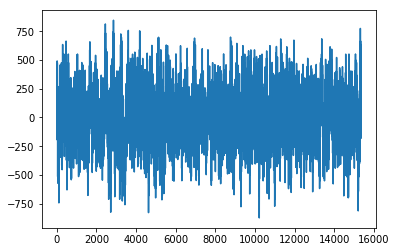

In [5]:
plt.plot(data['N'][3][5] - data['N'][43][5])

## New data

In [0]:
def New_Data_Generator_N():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['N'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['N'].append(new_data[person])
        person += 1

    
def New_Data_Generator_D():
    number_of_samples = 30
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['D'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['D'].append(new_data[person])
        person += 1

In [0]:
New_Data_Generator_N()
New_Data_Generator_D()

In [0]:
n_D , n_N = len(data['D']), len(data['N'])

In [9]:
n_D, n_N

(631, 567)

## Making Fourier Transform data set

In [10]:
index = np.arange(0,512*30)
f = np.linspace(0,512,512*30)
f_max = f[len(f[f<120])]
ind_min = 2
ind_max = list(index[f==f_max])[0]
f_min = f[ind_min]

print(f_min, f_max, ind_min, ind_max)


sam_FT = np.abs(fft(data['D'][50][7]))

# The 50 Htz noise elimination information

f_45 = f>45
f_55 = f<55
f_bar = f<45

for i in range(f.shape[0]):
  f_bar[i] = f_45[i] and f_55[i]
  
  
noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
noise_index = list(index[f==noise])[0] # in range 0, 512*30
del_domain = 40
del_range = [noise_index + i for i in range(-del_domain,del_domain)]
print(noise, noise_index)








0.06667100722703301 120.00781300865941 2 3600
50.03659092388827 1501


In [11]:
sam_FT[list(f<55) or list(f>45)].shape

(1650,)

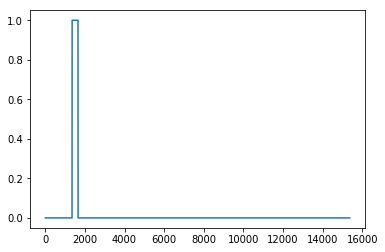

In [12]:
plt.plot(f_bar)

# Noise Delete

In [0]:
f = np.linspace(0,512,512*30)[ind_min:ind_max]

In [0]:
normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


FT = {'D':disorder,
     'N':normal}

from numpy.fft import fft

for d in range(n_D):
    for i in range(19):
        
        FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
        FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
        FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])
    
for n in range(n_N):
    for i in range(19):
        FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
        FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
        FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])
        

    FT['N'] = np.array(FT['N'])
    FT['D'] = np.array(FT['D'])

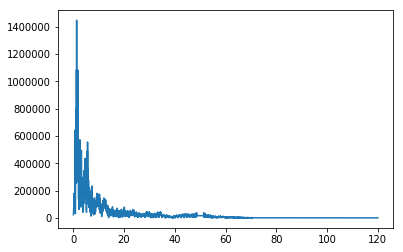

In [15]:
plt.plot(f, FT['N'][56][8])

In [0]:
%reset_selective -f "^data$"

# Data Shaper

In [0]:
FT_matrix_N = FT['N']
FT_matrix_D = FT['D']

temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
temp_N = FT_matrix_N.reshape((FT_matrix_N.shape[0],FT_matrix_N.shape[2],FT_matrix_N.shape[1]))
#or d in range(FT_matrix.shape[0]):
scaler = StandardScaler()

In [0]:
for n in range(FT_matrix_N.shape[0]):
  temp_N[n]= scaler.fit_transform(FT_matrix_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)
        

((631, 3598, 19), (567, 3598, 19))

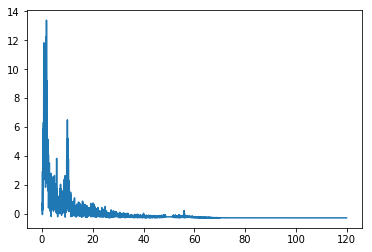

In [19]:
plt.plot(f,temp_D[3,:,4])

temp_D.shape, temp_N.shape

In [0]:
for n in range(FT_matrix_N.shape[0]):
  FT_matrix_N[n]= scaler.fit_transform(temp_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  FT_matrix_D[d]= scaler.fit_transform(temp_D[d].T)
        

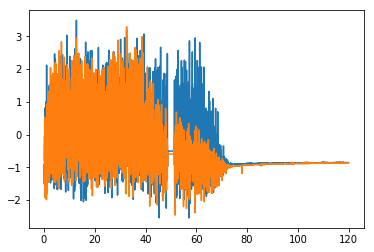

In [23]:
plt.plot(f,FT_matrix_D[8,8])
plt.plot(f,FT_matrix_D[65,8])


In [24]:
FT_matrix_D.shape, FT_matrix_N.shape

((631, 19, 3598), (567, 19, 3598))

# Data Shaper

In [0]:
# normal is 1 and disorder is 0
Data = np.vstack((FT_matrix_N, FT_matrix_D))
target = np.hstack((np.ones(FT_matrix_N.shape[0]), np.zeros(FT_matrix_D.shape[0])))

In [0]:
X, y = shuffle(Data, target)

# Neural Network 

In [27]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

Using TensorFlow backend.


In [28]:

model = Sequential([
    Flatten(input_shape=[X.shape[1],X.shape[2]]),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
    
])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 68362)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               20508900  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)              

In [30]:
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((898, 19, 3598), (300, 19, 3598), (898,), (300,))

In [32]:
his = model.fit(X_train, y_train, epochs=30, batch_size=4, validation_data=(X_test, y_test))

Train on 898 samples, validate on 300 samples
Epoch 1/30
898/898 [==============================] - 12s 13ms/step - loss: 5.6310 - acc: 0.5635 - val_loss: 5.9260 - val_acc: 0.6233
Epoch 2/30
898/898 [==============================] - 7s 7ms/step - loss: 6.2401 - acc: 0.4978 - val_loss: 7.1710 - val_acc: 0.5500
Epoch 3/30
898/898 [==============================] - 7s 7ms/step - loss: 4.4677 - acc: 0.5590 - val_loss: 5.0968 - val_acc: 0.5300
Epoch 4/30
898/898 [==============================] - 7s 7ms/step - loss: 2.7078 - acc: 0.5390 - val_loss: 0.7839 - val_acc: 0.5233
Epoch 5/30
898/898 [==============================] - 7s 7ms/step - loss: 1.8780 - acc: 0.5390 - val_loss: 0.6925 - val_acc: 0.5233
Epoch 6/30
898/898 [==============================] - 7s 7ms/step - loss: 1.5964 - acc: 0.5256 - val_loss: 0.6923 - val_acc: 0.5233
Epoch 7/30
898/898 [==============================] - 7s 7ms/step - loss: 1.3396 - acc: 0.5301 - val_loss: 0.6922 - val_acc: 0.5233
Epoch 8/30
898/898 [========

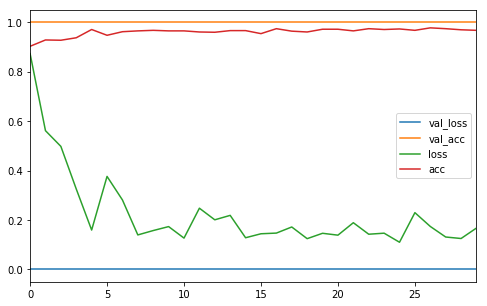

In [0]:
pd.DataFrame(his.history).plot(figsize=(8, 5))

In [0]:
def run_experiment(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X,y)
  
  model = Sequential([
    Flatten(input_shape=[X.shape[1],X.shape[2]]),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
    
  ])
  
  model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
  
  his = model.fit(X, y, epochs=30, batch_size=4, validation_data =(X_test, y_test) )
  